This notebook shows that the continuous and discrete adjoint methods give the same result if no stabilisation is applied.

In [1]:
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock, ProjectBlock

In [2]:
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [3]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

Specify 'optimum' and initial guess

In [4]:
m_opt = 5.0
m_prior = 10.0

Create `Options` object and setup gauges.

In [5]:
level = 2
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0', '80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())

/home/joe/software/firedrake-pragmatic/src/firedrake/firedrake/parloops.py:130: LoopyWarning: 'lang_version' was not passed to make_function(). To avoid this warning, pass lang_version=(2018, 2) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2' in the global scope of the calling frame.)
  knl = loopy.make_function(kernel_domains, instructions, kargs, seq_dependencies=True,


Setup timestepping parameters

In [6]:
num_timesteps = 30*2**level
dt = Constant(op.dt)
theta = Constant(0.5)

Create function spaces

In [7]:
mesh = op.default_mesh
P2 = VectorFunctionSpace(mesh, "CG", 1)
P1 = FunctionSpace(mesh, "CG", 1)
V = P2*P1
R = FunctionSpace(mesh, "R", 0)

Create `Function`s

In [8]:
u, eta = TrialFunctions(V)
test_u, test_eta = TestFunctions(V)
m = Function(R).assign(m_prior)
c = Control(m)
q0 = Function(V)
u0, eta0 = q0.split()
eta0.interpolate(gaussian([(0.7e+06, 4.2e+06, 48e+03, 96e+03)], mesh, rotation=pi/12))
q_ = Function(V)
u_, eta_ = q_.split();

In [9]:
# fig, axes = plt.subplots(figsize=(7, 6))
# tc = tricontourf(eta0, axes=axes, cmap='coolwarm')
# cb = plt.colorbar(tc, ax=axes)
# axes.axis(False);

Set physical parameters

In [10]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(9.81)

Setup forward variational problem

In [11]:
a = inner(u, test_u)*dx + eta*test_eta*dx
a += theta*dt*g*inner(grad(eta), test_u)*dx - theta*dt*b*inner(u, grad(test_eta))*dx
L = inner(u_, test_u)*dx + eta_*test_eta*dx
L += -(1-theta)*dt*g*inner(grad(eta_), test_u)*dx + (1-theta)*dt*b*inner(u_, grad(test_eta))*dx
q = Function(V)
u, eta = q.split()
bc = DirichletBC(V.sub(1), 0, 100)
problem = LinearVariationalProblem(a, L, q, bcs=bc)

Setup forward variational solver

In [12]:
sp = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}
solver = LinearVariationalSolver(problem, solver_parameters=sp)

Setup QoI

In [13]:
P0 = FunctionSpace(mesh, "DG", 0)
J_form = 0
radius = 20e+03*0.5**level
for gauge in gauges:
    op.gauges[gauge]["data"] = []
    k = Function(P0*P0)
    ku, keta = k.split()
    keta.interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,)], mesh))
    keta.assign(keta/assemble(keta*dx))
    op.gauges[gauge]["indicator"] = keta
    op.gauges[gauge]["obs"] = Function(R)
    op.gauges[gauge]["obs_old"] = Function(R)
    J_form += theta*0.5*dt*keta*(eta - op.gauges[gauge]["obs"])**2*dx
    J_form += (1-theta)*0.5*dt*keta*(eta_ - op.gauges[gauge]["obs_old"])**2*dx

In [14]:
# fig, axes = plt.subplots(figsize=(6, 6))
# tricontourf(keta, axes=axes, cmap='coolwarm')
# axes.axis(False);

Solve forward to generate 'data'

In [15]:
u_.assign(u0)
eta_.project(m_opt*eta0)
for gauge in gauges:
    op.gauges[gauge]["data"].append(float(eta_.at(op.gauges[gauge]["coords"])))
for i in range(num_timesteps):
    print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
    solver.solve()
    q_.assign(q)
    for gauge in gauges:
        op.gauges[gauge]["data"].append(float(eta.at(op.gauges[gauge]["coords"])))
print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")

t =   0.0 min  ||u|| = 0.0000e+00  ||eta|| = 0.0000e+00
t =   0.2 min  ||u|| = 1.4483e+03  ||eta|| = 4.2366e+05
t =   0.5 min  ||u|| = 2.8814e+03  ||eta|| = 4.2073e+05
t =   0.8 min  ||u|| = 4.2853e+03  ||eta|| = 4.1598e+05
t =   1.0 min  ||u|| = 5.6470e+03  ||eta|| = 4.0959e+05
t =   1.2 min  ||u|| = 6.9557e+03  ||eta|| = 4.0180e+05
t =   1.5 min  ||u|| = 8.2022e+03  ||eta|| = 3.9289e+05
t =   1.8 min  ||u|| = 9.3798e+03  ||eta|| = 3.8312e+05
t =   2.0 min  ||u|| = 1.0484e+04  ||eta|| = 3.7281e+05
t =   2.2 min  ||u|| = 1.1513e+04  ||eta|| = 3.6221e+05
t =   2.5 min  ||u|| = 1.2464e+04  ||eta|| = 3.5158e+05
t =   2.8 min  ||u|| = 1.3340e+04  ||eta|| = 3.4115e+05
t =   3.0 min  ||u|| = 1.4141e+04  ||eta|| = 3.3111e+05
t =   3.2 min  ||u|| = 1.4870e+04  ||eta|| = 3.2162e+05
t =   3.5 min  ||u|| = 1.5531e+04  ||eta|| = 3.1281e+05
t =   3.8 min  ||u|| = 1.6126e+04  ||eta|| = 3.0476e+05
t =   4.0 min  ||u|| = 1.6661e+04  ||eta|| = 2.9754e+05
t =   4.2 min  ||u|| = 1.7140e+04  ||eta|| = 2.9

In [16]:
# fig, axes = plt.subplots(figsize=(7, 6))
# tc = tricontourf(eta, axes=axes, cmap='coolwarm')
# cb = plt.colorbar(tc, ax=axes)
# axes.axis(False);

In [17]:
adj_free_form = 0
for gauge in gauges:
    adj_free_form += theta*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*eta*dx
    adj_free_form += (1-theta)*dt*op.gauges[gauge]["indicator"]*(eta_ - op.gauges[gauge]["obs_old"])*eta_*dx

Solve forward to annotate to tape

In [18]:
J = 0
adj_free = 0
u_.assign(u0)
eta_.project(m*eta0)
solutions = [q_.copy(deepcopy=True)]
for i in range(num_timesteps):
    print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
    solver.solve()
    solutions.append(q.copy(deepcopy=True))
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    J = J + assemble(J_form)
    adj_free = adj_free + assemble(adj_free_form, annotate=False)
    q_.assign(q)
J10 = float(J)
gaf10 = float(adj_free)/10
print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
stop_annotating();

t =   0.0 min  ||u|| = 4.9250e+04  ||eta|| = 3.0117e+05
t =   0.2 min  ||u|| = 2.8965e+03  ||eta|| = 8.4732e+05
t =   0.5 min  ||u|| = 5.7628e+03  ||eta|| = 8.4146e+05
t =   0.8 min  ||u|| = 8.5706e+03  ||eta|| = 8.3196e+05
t =   1.0 min  ||u|| = 1.1294e+04  ||eta|| = 8.1918e+05
t =   1.2 min  ||u|| = 1.3911e+04  ||eta|| = 8.0361e+05
t =   1.5 min  ||u|| = 1.6404e+04  ||eta|| = 7.8577e+05
t =   1.8 min  ||u|| = 1.8760e+04  ||eta|| = 7.6625e+05
t =   2.0 min  ||u|| = 2.0968e+04  ||eta|| = 7.4561e+05
t =   2.2 min  ||u|| = 2.3025e+04  ||eta|| = 7.2441e+05
t =   2.5 min  ||u|| = 2.4928e+04  ||eta|| = 7.0316e+05
t =   2.8 min  ||u|| = 2.6679e+04  ||eta|| = 6.8230e+05
t =   3.0 min  ||u|| = 2.8281e+04  ||eta|| = 6.6222e+05
t =   3.2 min  ||u|| = 2.9740e+04  ||eta|| = 6.4325e+05
t =   3.5 min  ||u|| = 3.1061e+04  ||eta|| = 6.2562e+05
t =   3.8 min  ||u|| = 3.2253e+04  ||eta|| = 6.0952e+05
t =   4.0 min  ||u|| = 3.3323e+04  ||eta|| = 5.9507e+05
t =   4.2 min  ||u|| = 3.4279e+04  ||eta|| = 5.8

In [19]:
# fig, axes = plt.subplots(figsize=(7, 6))
# tricontourf(eta, axes=axes, cmap='coolwarm')
# cb = plt.colorbar(tc, ax=axes)
# axes.axis(False);

Create `ReducedFunctional` and compute gradient using discrete adjoint

In [20]:
Jhat = ReducedFunctional(J, c)
gd10 = Jhat.derivative().dat.data[0]

In [21]:
# _J10 = Jhat(10.0)
# assert np.isclose(J10, _J10), f"{_J10} vs. {J10}"

In [22]:
# minconv = taylor_test(Jhat, Function(R).assign(10.0), Function(R).assign(0.1))
# assert minconv > 1.90, f"{minconv}"

Setup continuous adjoint variational problem and solver

In [23]:
phi = TestFunction(V)
cont_adj = Function(V)
z, zeta = cont_adj.split()
cont_adj_ = Function(V)
z_, zeta_ = cont_adj_.split()
a_star = adjoint(a)

In [24]:
w1 = Constant(1.0)
w2 = Constant(0.0)
L_star = replace(L, {test_u: z_, test_eta: zeta_, u_: test_u, eta_: test_eta})
for gauge in gauges:
    L_star += w1*theta*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*test_eta*dx
    L_star += w2*(1-theta)*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*test_eta*dx

In [25]:
adj_problem = LinearVariationalProblem(a_star, L_star, cont_adj, bcs=bc)
adj_solver = LinearVariationalSolver(adj_problem, solver_parameters=sp)

Solve continuous adjoint problem

In [26]:
for i in range(num_timesteps-1, -1, -1):
    if i == num_timesteps-2:
        w2.assign(1.0)
    print(f"t = {(i+1)*op.dt/60:5.1f} min  ||z|| = {norm(z):.4e}  ||zeta|| = {norm(zeta):.4e}")
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    q.assign(solutions[i+1])
    q_.assign(solutions[i])
    adj_solver.solve()
    cont_adj_.assign(cont_adj)
print(f"t = {0*op.dt/60:5.1f} min  ||z|| = {norm(z):.4e}  ||zeta|| = {norm(zeta):.4e}")

t =  30.0 min  ||z|| = 0.0000e+00  ||zeta|| = 0.0000e+00
t =  29.8 min  ||z|| = 1.7072e-03  ||zeta|| = 2.9463e-03
t =  29.5 min  ||z|| = 8.2094e-03  ||zeta|| = 8.5580e-03
t =  29.2 min  ||z|| = 2.0176e-02  ||zeta|| = 1.3532e-02
t =  29.0 min  ||z|| = 3.5944e-02  ||zeta|| = 1.7679e-02
t =  28.8 min  ||z|| = 5.3614e-02  ||zeta|| = 2.1021e-02
t =  28.5 min  ||z|| = 7.1474e-02  ||zeta|| = 2.3755e-02
t =  28.2 min  ||z|| = 8.8324e-02  ||zeta|| = 2.6155e-02
t =  28.0 min  ||z|| = 1.0363e-01  ||zeta|| = 2.8448e-02
t =  27.8 min  ||z|| = 1.1743e-01  ||zeta|| = 3.0733e-02
t =  27.5 min  ||z|| = 1.3015e-01  ||zeta|| = 3.2979e-02
t =  27.2 min  ||z|| = 1.4229e-01  ||zeta|| = 3.5093e-02
t =  27.0 min  ||z|| = 1.5421e-01  ||zeta|| = 3.6987e-02
t =  26.8 min  ||z|| = 1.6605e-01  ||zeta|| = 3.8620e-02
t =  26.5 min  ||z|| = 1.7772e-01  ||zeta|| = 4.0002e-02
t =  26.2 min  ||z|| = 1.8903e-01  ||zeta|| = 4.1176e-02
t =  26.0 min  ||z|| = 1.9978e-01  ||zeta|| = 4.2193e-02
t =  25.8 min  ||z|| = 2.0983e-

In [27]:
tape = get_working_tape()
solve_blocks = [
    block
    for block in tape.get_blocks()
    if issubclass(type(block), GenericSolveBlock)
    and not issubclass(type(block), ProjectBlock)
    and block.adj_sol is not None
]

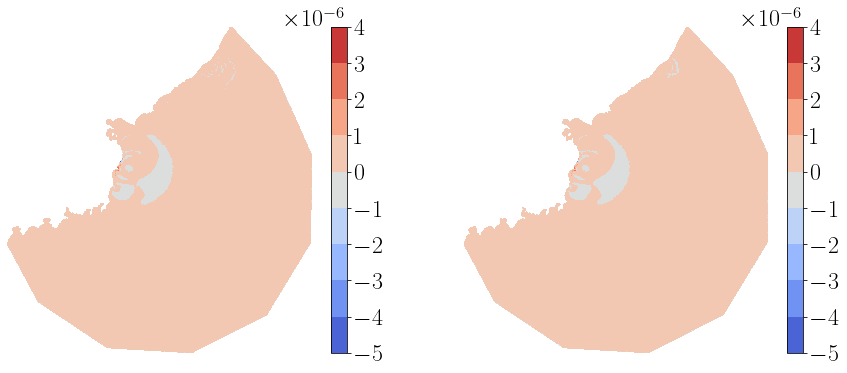

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
tc = tricontourf(zeta, axes=axes[0], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[0])
axes[0].axis(False)
disc_adj = solve_blocks[0].adj_sol
tc = tricontourf(disc_adj.split()[1], axes=axes[1], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[1])
axes[1].axis(False);

In [29]:
assert np.allclose(disc_adj.dat.data[1], cont_adj.dat.data[1])

Compute gradient using continuous adjoint method and check that it matches

In [30]:
gc = eta0*zeta*dx \
    - (1-theta)*dt*g*inner(grad(eta0), z)*dx
for gauge in gauges:
    op.gauges[gauge]['obs0'] = Function(R).assign(op.gauges[gauge]['data'][0])
    gc += dt*(1-theta)*op.gauges[gauge]['indicator']*(m*eta0 - op.gauges[gauge]['obs0'])*eta0*dx
gc10 = assemble(gc)

Sample control space at two more points and compute the discrete adjoint gradient at 5

In [31]:
J2 = Jhat(m.assign(2.0))
J5 = Jhat(m.assign(5.0))
gd5 = Jhat.derivative().dat.data[0]

In [32]:
# minconv = taylor_test(Jhat, Function(R).assign(5.0), Function(R).assign(0.1))
# assert minconv > 1.90, f"{minconv}"

Rerun the forward solver at 5

In [33]:
J = 0
adj_free = 0
u_.assign(0.0)
eta_.project(5*eta0)
solutions = [q_.copy(deepcopy=True)]
for i in range(num_timesteps):
    solver.solve()
    solutions.append(q.copy(deepcopy=True))
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    J = J + assemble(J_form)
    adj_free = adj_free + assemble(adj_free_form, annotate=False)
    q_.assign(q)
gaf5 = float(adj_free)/5
assert np.isclose(float(J), J5), f"{float(J)} vs. {J5}"

Compute the continuous adjoint gradient

In [34]:
w1.assign(1.0)
w2.assign(0.0)
cont_adj_.assign(0.0)
for i in range(num_timesteps-1, -1, -1):
    if i == num_timesteps-2:
        w2.assign(1.0)
    for gauge in gauges:
        op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
        op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
    q.assign(solutions[i+1])
    q_.assign(solutions[i])
    adj_solver.solve()
    cont_adj_.assign(cont_adj)
gc5 = assemble(gc)

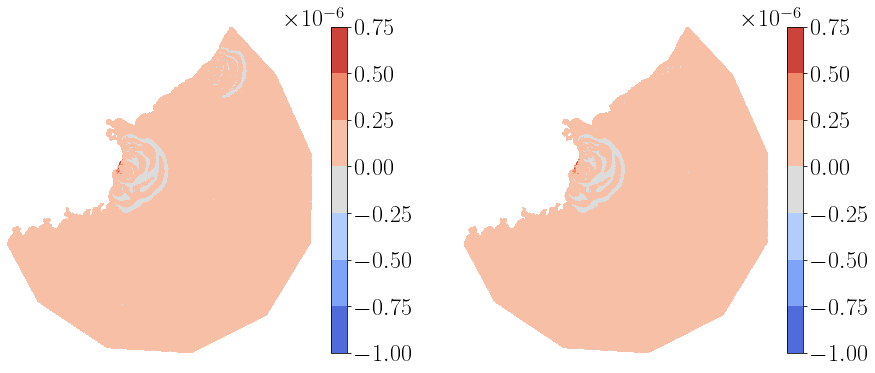

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
tc = tricontourf(zeta, axes=axes[0], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[0])
axes[0].axis(False)
disc_adj = solve_blocks[0].adj_sol
tc = tricontourf(solve_blocks[0].adj_sol.split()[1], axes=axes[1], cmap='coolwarm')
cb = plt.colorbar(tc, ax=axes[1])
axes[1].axis(False);

In [36]:
assert np.allclose(disc_adj.dat.data[1], cont_adj.dat.data[1])

In [37]:
l = si.lagrange([2, 5, 10], [J2, J5, J10])
dl = l.deriv()
l_min = -dl.coefficients[1]/dl.coefficients[0]
print("Minimiser of quadratic: {:.4f}".format(l_min))

Minimiser of quadratic: 4.9080


In [38]:
print(f"Exact gradient at 10              = {dl(10.0)}")
print(f"Discrete adjoint gradient at 10   = {gd10}")
print(f"Continuous adjoint gradient at 10 = {gc10}")
print(f"Adjoint-free gradient at 10       = {gaf10}")

Exact gradient at 10              = 2228.0384278360125
Discrete adjoint gradient at 10   = 2228.0383283660453
Continuous adjoint gradient at 10 = 2228.0383820165493
Adjoint-free gradient at 10       = 2228.038431823684


In [39]:
print(f"Exact gradient at  5              = {dl(5.0)}")
print(f"Discrete adjoint gradient at 5    = {gd5}")
print(f"Continuous adjoint gradient at 5  = {gc5}")
print(f"Adjoint-free gradient at 5        = {gaf5}")

Exact gradient at  5              = 40.2428032326352
Discrete adjoint gradient at 5    = 40.24279722428529
Continuous adjoint gradient at 5  = 40.24280986944017
Adjoint-free gradient at 5        = 40.24281066484694


### $m = 10,\quad\theta=\frac12$

| Mesh | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 2141.207639251425 | 2141.207581531595 | 2141.2075199664973 | 2141.207638910488 |
| $\mathcal H_1$ | 2275.5510264476075 | 2275.550921650117 | 2275.550892507928 | 2275.551029280662 |
| $\mathcal H_2$ | 2228.0384278360125 | 2228.0383283660453 | 2228.0383283660453 | 2228.038431823684 |

### $m=5,\quad\theta=\frac12$

| Mesh | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 329.2900712222381 | 329.290042780578 | 329.2900738160331 | 329.29009819835346 |
| $\mathcal H_1$ | 183.3292628868444 | 183.3292423840532 | 183.32925540741326 | 183.32927353150936 |
| $\mathcal H_2$ | 40.2428032326352 | 40.24279722428529 | 40.24280986944017 | 40.24281066484694 |

### $m = 10,\quad\theta=1$

| Mesh | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 996.946711548131 | 996.9466818678358 | 996.9466789234594 | 996.9467112931563 |

### $m=5,\quad\theta=1$

| Mesh | Exact | Discrete adjoint gradient | Continuous adjoint gradient | Adjoint-free gradient |
| --- | --- | --- | --- | --- |
| $\mathcal H_0$ | 84.64720043647787 | 84.64719576829249 | 84.64719576829249 | 84.64719576829249 |

Plot the parameter space

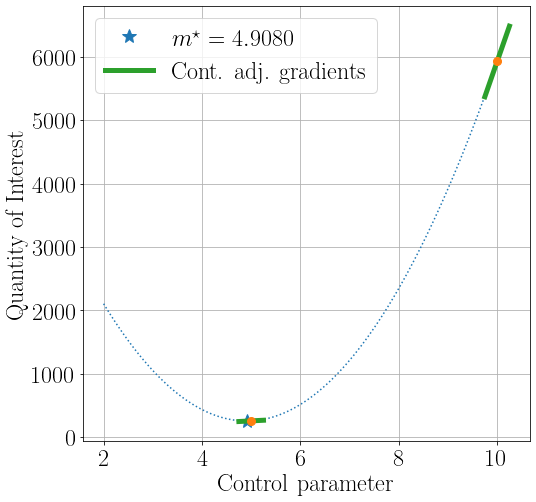

In [40]:
fig, axes = plt.subplots(figsize=(8, 8))
xx = np.linspace(2, 10, 100)
axes.plot(xx, l(xx), ':', color='C0')
axes.plot(l_min, l(l_min), '*', markersize=14, color='C0', label=r"$m^\star={:.4f}$".format(l_min))

delta_m = 0.25
m = [5.0, 10.0]
f = [J5, J10]
for i, (mi, fi, gi) in enumerate(zip(m, f, [gc5, gc10])):
    x = np.array([mi - delta_m, mi + delta_m])
    axes.plot(x, gi*(x - mi) + fi, '-', color='C2', linewidth=5, label='Cont. adj. gradients' if i == 0 else None)
axes.plot(m, f, 'o', color='C1', markersize=8)

axes.set_xlabel("Control parameter")
axes.set_ylabel("Quantity of Interest")
axes.grid(True)
axes.legend();

Minimisers for $\theta=\frac12$: 4.0913, 4.5619, 4.9221.
Minimisers for $\theta=1$: 4.5361